# Sub Class 모델링

모델 이란 것은 Input을 Output으로 만들어주는 수식이다. 

해당 기능을 수행하는 두 가지 클래스가 `tf.keras.layers.Layer` 와 `tf.keras.layers.Model` 클래스이다. 

두가지 모두 **연산을 추상화** 하는 것으로 동일한 역할을 하지만, `tf.keras.layers.Model` 클래스의 경우 모델을 저장 하는 기능 과 `fit` 함수를 사용할 수 있다는 점에서 차이가 있다. 

- tf.keras.layers.Layer
- tf.keras.layers.Model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

### Linear Regression을 Layer로 만들어 보자. 

In [3]:
class LinearRegression(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LinearRegression, self).__init__() # super로 상속을 받아와
        self.units = units
        # self.w = tf.Variable(tf.random.normal) ~~ -> 오버라이딩으로 구현

    def build(self, input_shape): # 오버라이딩에 쓸 변수를 build로 만들어 놓는게 좋다한다.
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), # [-1]로 피처개수 추출
            initializer="random_normal",
            trainable=True,
        )
        self.b = tf.Variable(0.0)

    def call(self, inputs): # 오버라이딩
        return tf.matmul(inputs, self.w) + self.b

### 가상 데이터

In [4]:
W_true = np.array([[3., 2., 4., 1.]]).reshape((4, 1)) # [4] -> [4x1]
B_true = np.array([1.])

X = tf.random.normal((500, 4))
noise = tf.random.normal((500, 1))

y = X @ W_true + B_true + noise

In [5]:
opt = tf.keras.optimizers.SGD(learning_rate=3e-2)


linear_layer = LinearRegression(1) # unit = 1

for epoch in range(100): # 100번 반복
    
    with tf.GradientTape() as tape: # 연산 하고 tape 에 저장
        y_hat = linear_layer(X)
        loss = tf.reduce_mean(tf.square((y - y_hat)))
        
    grads = tape.gradient(loss, linear_layer.trainable_weights)
    
    # 자동 최적화  ->  # 수작업 w.assing_sub(lr*b)
    opt.apply_gradients(zip(grads, linear_layer.trainable_weights))
    
    if epoch % 10 == 0:
        print("epoch : {} loss : {}".format(epoch, loss.numpy()))

epoch : 0 loss : 33.177921295166016
epoch : 10 loss : 9.759605407714844
epoch : 20 loss : 3.3366031646728516
epoch : 30 loss : 1.570228099822998
epoch : 40 loss : 1.0829838514328003
epoch : 50 loss : 0.9481186866760254
epoch : 60 loss : 0.9106446504592896
epoch : 70 loss : 0.9001870155334473
epoch : 80 loss : 0.8972545266151428
epoch : 90 loss : 0.8964279294013977


In [6]:
linear_layer(X[:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7251956]], dtype=float32)>

### ResNet - Sub Class 로 구현 하기 

1. Residual Block - Layer
    - 반복되는 레이어를 하나의 블럭(레이어)으로 클래스화(은닉화)

2. ResNet  - Model

- super() : 부모 클래스에 대한 액세스를 지시하고 부모 클래스(tensorflow.keras.Model)의 생성자 함수를 호출한다.


- init : 객체를 정의하자마자 실행되는 생성자, 객체를 처음 실행할 때(선언할 때) 자동으로 실행(호출)되는 생성자


- call : 객체를 만들어 놓고 나중에 사용할때 사용되는 함수, 객체모델의 입력이 곧 call함수의 입력이 됨.

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [8]:
class ResidualBlock(tf.keras.layers.Layer): # Layer를 super로 상속
    
    # filter_match라는 조건을 준다 : True면 차원을 맞춰 더하는 작업을 따로 진행 
    def __init__(self, filters=32, filter_match=False):
        super(ResidualBlock, self).__init__()
        
        # 컨벌루션레이어 1,2,3 정의 및 add 정의
        self.conv1 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')
        self.conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')
        self.conv3 = Conv2D(filters, kernel_size=1, padding='same', activation='relu')
        self.add = Add()
        
        self.filters = filters
        self.filter_match = filter_match
        if filter_match: #
            self.conv_ext = Conv2D(filters, kernel_size=1, padding='same')
        
    def call(self, inputs):
        net1 = self.conv1(inputs)
        net2 = self.conv2(net1)
        net3 = self.conv3(net2)
        if self.filter_match:
            res = self.add([self.conv_ext(inputs), net3])
        else: 
            res = self.add([inputs, net3])
        return res 
        
        

In [9]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')
        self.maxp1 =  MaxPool2D()
        self.block_1 = ResidualBlock(64, True) # 생성자 -> filters = 64, match = True
        self.block_2 = ResidualBlock(64)       # 생성자 -> filters = 64, match = False
        self.maxp2 =  MaxPool2D()
        self.flat = Flatten()
        self.dense = Dense(num_classes)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxp1(x)
        x = self.block_1(x) # call 함수의 inputs -> x
        x = self.block_2(x) # call 함수의 inputs -> x
        x = self.maxp2(x)
        x = self.flat(x)
        return self.dense(x)

model = ResNet(num_classes=10)

### 학습 시켜보기

In [10]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [11]:
cifar10_loader = Cifar10DataLoader()

train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = cifar10_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32
(10000, 32, 32, 3) float32
(10000, 10) float32


In [12]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [13]:
hist = model.fit(train_x, train_y,
                 epochs=10, batch_size=128,
                 validation_data=(test_x, test_y))

Epoch 1/10
391/391 [==============================] - 24s 38ms/step - loss: 8.0411 - accuracy: 0.0995 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 2/10
391/391 [==============================] - 13s 34ms/step - loss: 8.0591 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 13s 34ms/step - loss: 8.0590 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 13s 34ms/step - loss: 8.0591 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 13s 34ms/step - loss: 8.0590 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 8.0591 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 13s 33ms/step - loss: 8.0590 - accuracy: 0.1000 - val_loss: 8.0590 - val_accuracy:

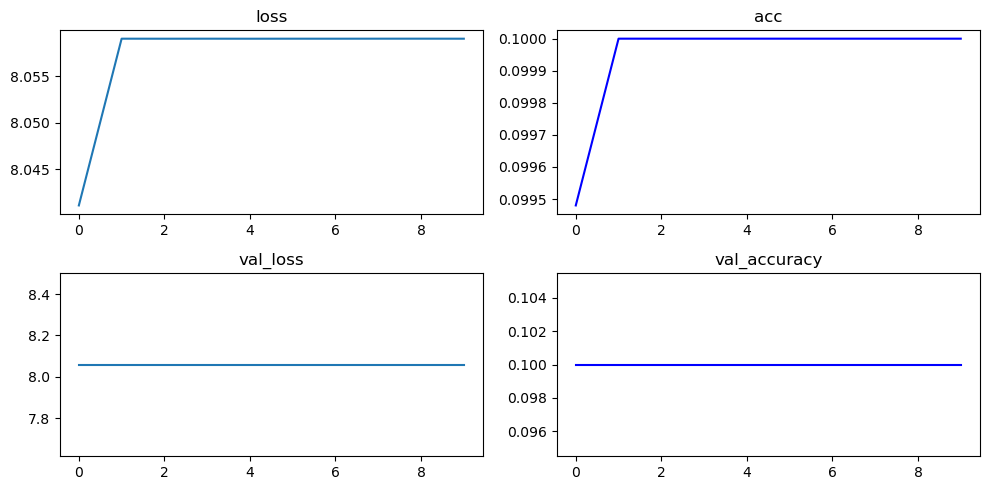

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()